In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap

cmap = get_cmap('bwr')

plt.style.use('seaborn-dark')

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (15, 5)

from scipy import signal
from itertools import product

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import matplotlib.ticker as ticker

# os.chdir('/home/bruno/datacloud')

In [2]:
from theory.core import TheoreticalWavelet, Pipe, Rock

# This is a function where our feature extraction is happening

In [3]:
def feature_extractor(wavelet, time, 
                      center_window=None, 
                      left_window=None, 
                      right_window=None,
                      center_pick='max',
                      left_pick='min',
                      right_pick='min',
                      upsample_to=100000):
    time = np.linspace(time.min(), time.max(), upsample_to)
    wavelet = signal.resample(wavelet, upsample_to)

    extracted_features = {}
    for pick, window, window_name in  zip([center_pick, left_pick, right_pick], [center_window, left_window, right_window], ['center', 'left', 'right']):
        if window:
            constrained_indices = np.where((time > window[0]) & (time < window[1]))

            constrained_wavelet = np.zeros_like(wavelet)
            constrained_wavelet[constrained_indices] = wavelet[constrained_indices]
            if pick == 'max':
                feature_index = np.argmax(constrained_wavelet)
            elif pick == 'min':
                feature_index = np.argmin(constrained_wavelet)
            else:
                raise ValueError('picks must be "min" or "max"')

            delay = time[feature_index]
            amplitude = wavelet[feature_index]
            extracted_features[window_name] = {
                'delay': delay,
                'amplitude': amplitude,
                'feature_index': feature_index,
            }
    try:
        extracted_features['center_to_left_ratio'] = extracted_features['center']['amplitude'] / extracted_features['left']['amplitude']
        extracted_features['right_to_left_ratio'] = extracted_features['right']['amplitude'] / extracted_features['left']['amplitude']
        extracted_features['left_to_center_delay'] = extracted_features['left']['delay'] / extracted_features['center']['delay']
        extracted_features['center_to_right_delay'] = extracted_features['center']['delay'] / extracted_features['right']['delay']
    except:
        pass
    return extracted_features

# PLAYGROUND BEFORE MODELING 

This is where we can visualize the wavelets with the pick on top of it given a range of values.
Its useful to visualize what times to expect and plan the windows boundaries.

## Playground parameters

In [4]:
COMPONENT = 'axial'

WINDOW = 310 # window in time domain by number of samples

ALPHA_OR_BETA_RANGE = np.arange(100, 1500 + 25, 25)
# RHO_RANGE = np.arange(1500, 3000 + 500, 500)
RHO_RANGE = np.asarray([2000])
Rb = 0.16 # radius of the bit contacting rock

BANDPASS_FILTER = [30, 45, 160, 200]
UPSAMPLE_TO = 100000

RC_AXIAL = 0.301 # reflection coefficient
DELAY_BITSUB_AXIAL = 0.667 # in ms

RC_TANGENTIAL = -0.158  # reflection coefficient
DELAY_BITSUB_TANGENTIAL = 1.37 # in ms

AXIAL_FEATURE_EXTRACTOR = dict(
    center_window=(-.002, 0.005), # left, right 
    left_window=(-.008, -.002), 
    right_window=(0.005, 0.01),
    center_pick='max',
    left_pick='min',
    right_pick='min',
)

TANGENTIAL_FEATURE_EXTRACTOR = dict(
    center_window=(-.004, 0.004), # left, right
    left_window=(-.01, -.001), 
    right_window=(0.002, 0.015),
    center_pick='max',
    left_pick='min',
    right_pick='min',
)

PIPE_ALPHA = 4875 # velocity of the pipe
PIPE_BETA = 2368
PIPE_RHO = 7850 # density of the pipe

CONTACT_FACTOR_AXIAL=1
CONTACT_FACTOR_TANGENTIAL=1

100%|██████████| 57/57 [00:03<00:00, 14.28it/s]


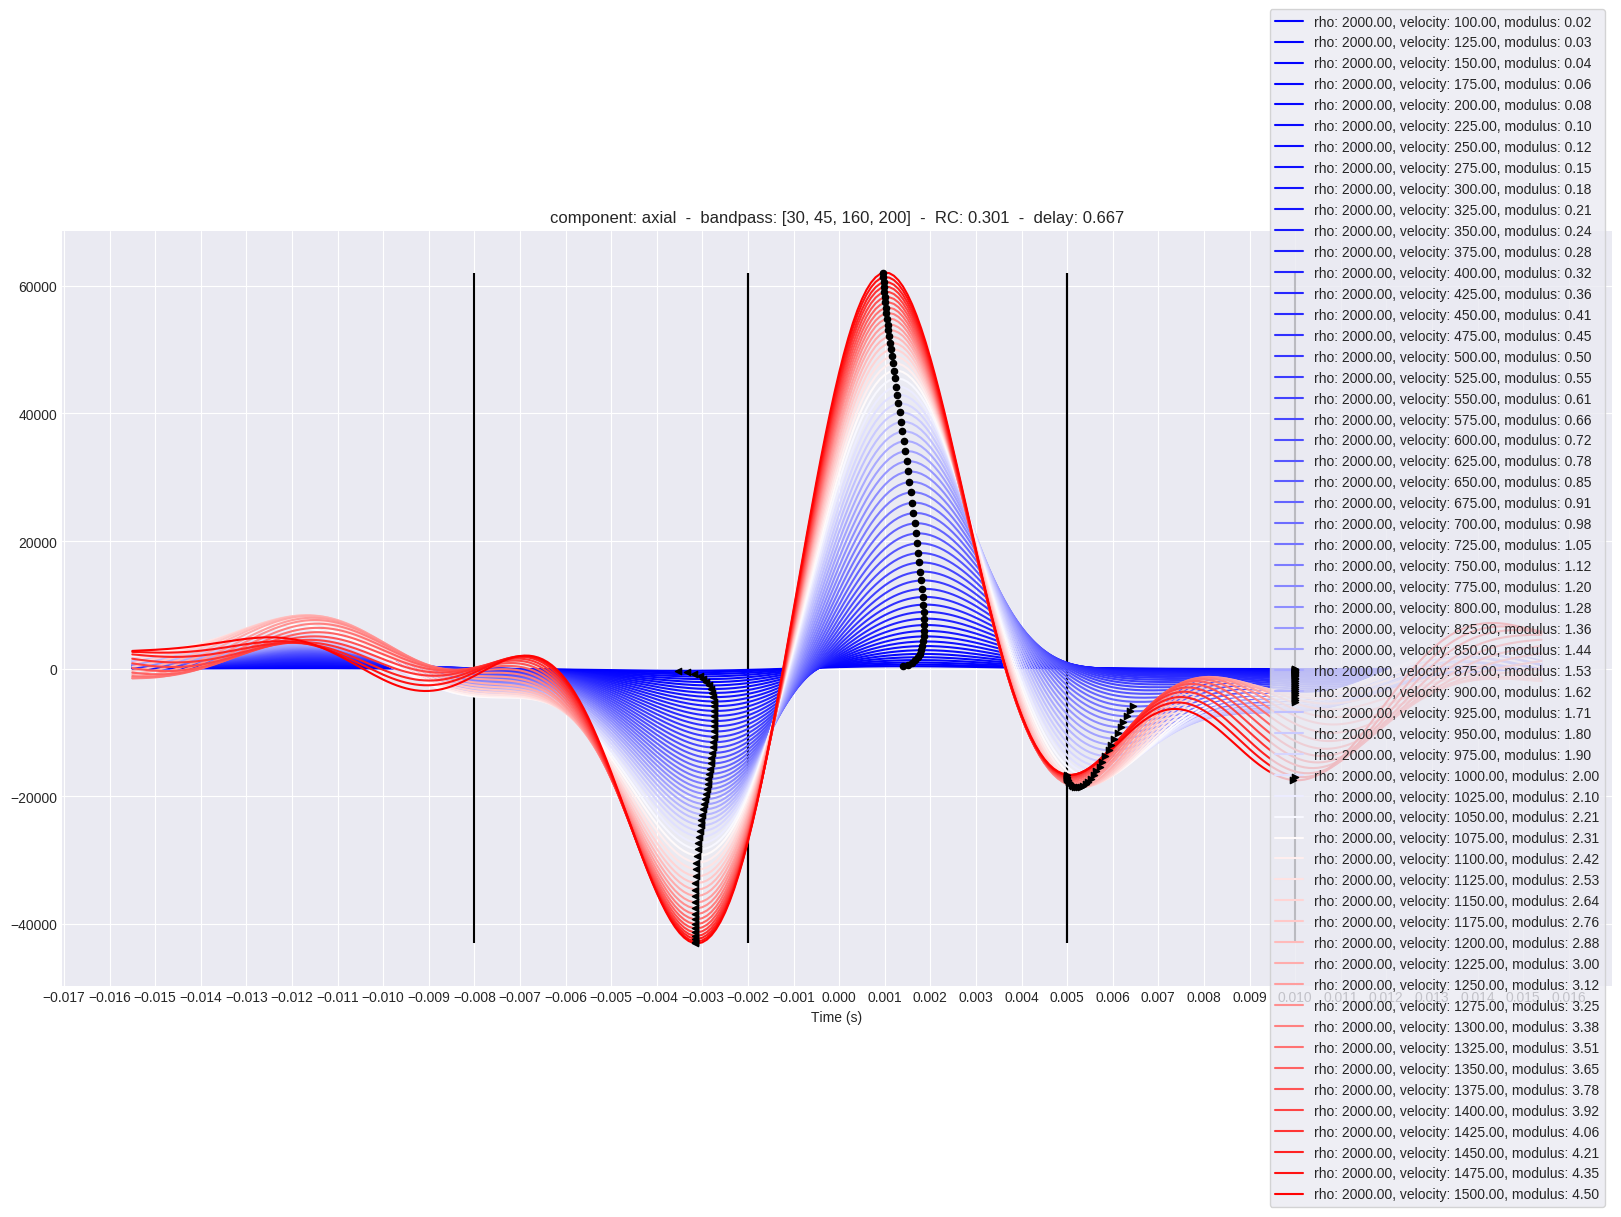

In [5]:
mod_range = (np.product(list(product((ALPHA_OR_BETA_RANGE/1000)**2, (RHO_RANGE/1000))), axis=1))
min_mod, max_mod = mod_range.min(), mod_range.max()

if COMPONENT == 'axial':
    pipe = Pipe(Rb=Rb, alpha=PIPE_ALPHA, rho=PIPE_RHO, beta=PIPE_BETA, contact_factor=CONTACT_FACTOR_AXIAL)
else:
    pipe = Pipe(Rb=Rb, alpha=PIPE_ALPHA, rho=PIPE_RHO, beta=PIPE_BETA, contact_factor=CONTACT_FACTOR_TANGENTIAL)
    
ax = plt.axes()
for a, r in tqdm(product(ALPHA_OR_BETA_RANGE, RHO_RANGE), total=len(list(product(ALPHA_OR_BETA_RANGE, RHO_RANGE)))):
    mod = ((r/1000)*((a/1000)**2))
    rock = Rock(alpha=a, beta=a, rho=r)

    theoretical = TheoreticalWavelet(pipe, rock, component=COMPONENT, nyquist=5000, filterby=BANDPASS_FILTER)
    time = theoretical.get_time_range_for_window(WINDOW)/1000
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)      
    if COMPONENT == 'axial':
        w += theoretical.pegleg_rocksteel(delay_in_ms=DELAY_BITSUB_AXIAL, RC=RC_AXIAL, window=None,)
    else:
        w += theoretical.pegleg_rocksteel(delay_in_ms=DELAY_BITSUB_TANGENTIAL, RC=RC_TANGENTIAL, window=None)
        
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    wavelet_full = theoretical.get_window_from_center(WINDOW, w)
    
    if COMPONENT == 'axial':
        extracted_features = feature_extractor(wavelet_full, time, **AXIAL_FEATURE_EXTRACTOR, upsample_to=UPSAMPLE_TO)
    else:
        extracted_features = feature_extractor(wavelet_full, time, **TANGENTIAL_FEATURE_EXTRACTOR, upsample_to=UPSAMPLE_TO)
    
    ax.plot(time, wavelet_full, color=cmap((mod-min_mod)/max_mod), zorder=5, label='rho: {:.2f}, velocity: {:.2f}, modulus: {:.2f}'.format(r, a, mod))
    ax.scatter(extracted_features['center']['delay'], extracted_features['center']['amplitude'], s=20, c='k', zorder=10)
    ax.scatter(extracted_features['left']['delay'], extracted_features['left']['amplitude'], s=20, c='k', zorder=10, marker="<")
    ax.scatter(extracted_features['right']['delay'], extracted_features['right']['amplitude'], s=20, c='k', zorder=10, marker=">")

ax.figure.dpi = 100
ax.figure.set_size_inches(20,10)
ax.legend(loc='right', frameon=True)

if COMPONENT == 'axial':
    ax.vlines(AXIAL_FEATURE_EXTRACTOR['center_window'], w.min(), w.max())
    ax.vlines(AXIAL_FEATURE_EXTRACTOR['left_window'], w.min(), w.max())
    ax.vlines(AXIAL_FEATURE_EXTRACTOR['right_window'], w.min(), w.max())
    ax.set_title('component: {}  -  bandpass: {}  -  RC: {}  -  delay: {}'.format(COMPONENT, BANDPASS_FILTER, round(RC_AXIAL, 3), round(DELAY_BITSUB_AXIAL, 3)))
    
else:
    ax.vlines(TANGENTIAL_FEATURE_EXTRACTOR['center_window'], w.min(), w.max())
    ax.vlines(TANGENTIAL_FEATURE_EXTRACTOR['left_window'], w.min(), w.max())
    ax.vlines(TANGENTIAL_FEATURE_EXTRACTOR['right_window'], w.min(), w.max())
    ax.set_title('component: {}  -  bandpass: {}  -  RC: {}  -  delay: {}'.format(COMPONENT, BANDPASS_FILTER, round(RC_TANGENTIAL, 3), round(DELAY_BITSUB_TANGENTIAL, 3)))    

    
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.001))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    
t = ax.set_xlabel('Time (s)')

# PARAMETERS FOR THE MODELING

In [6]:
MINE = 'Teck - Line Creek'
BANDPASS_FILTER = [30, 45, 160, 200]
UPSAMPLE_TO = 1000000

RC_AXIAL = 0.301 # reflection coefficient
DELAY_BITSUB_AXIAL = 0.667 # in ms

RC_TANGENTIAL = -0.158  # reflection coefficient
DELAY_BITSUB_TANGENTIAL = 1.37 # in ms

MODULUS_RANGE = (1, 10) # Minimum and maximum modulus values you want to model

Rb = 0.16 # Rb is the radius of the bit contacting rock

AXIAL_FEATURE_EXTRACTOR = dict(
    center_window=(-.002, 0.005), 
    left_window=(-.008, -.002), 
    right_window=(0.005, 0.01),
    center_pick='max',
    left_pick='min',
    right_pick='min',
)

TANGENTIAL_FEATURE_EXTRACTOR = dict(
    center_window=(-.004, 0.004), 
    left_window=(-.01, -.001), 
    right_window=(0.002, 0.015),
    center_pick='max',
    left_pick='min',
    right_pick='min',
)

PIPE_ALPHA = 4875 # velocity of the pipe
PIPE_BETA = 2368
PIPE_RHO = 7850 # density of the pipe

ROCK_ALPHA_RANGE = (500, 4000, 200) # range of the c velocity modeling
ROCK_BETA_RANGE = (300, 2000, 50) # range of the s velocity modeling
ROCK_RHO_RANGE = (1500, 3000 + 500, 500) # range of the density modeling

CONTACT_FACTOR_AXIAL = 1
CONTACT_FACTOR_TANGENTIAL = 1

# Modeling Axial Times 

In [7]:
alpha_range = np.arange(*ROCK_ALPHA_RANGE)
RHO_RANGE = np.arange(*ROCK_RHO_RANGE)

axial_delays = []
axial_modulus = []
axial_right_to_left_ratio = []
axial_center_to_left_ratio = []


pipe = Pipe(Rb=Rb, alpha=PIPE_ALPHA, rho=PIPE_RHO, beta=PIPE_BETA, contact_factor=CONTACT_FACTOR_AXIAL)

axial_wavelets = []
for a, r in tqdm(product(alpha_range, RHO_RANGE), total=len(list(product(alpha_range, RHO_RANGE)))):
    rock = Rock(alpha=a, beta=a, rho=r)
    theoretical = TheoreticalWavelet(pipe, rock, component='axial', nyquist=5000, filterby=BANDPASS_FILTER)
    time = theoretical.get_time_range_for_window(WINDOW)/1000
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                              
    w += theoretical.pegleg_rocksteel(delay_in_ms=DELAY_BITSUB_AXIAL, RC=RC_AXIAL, window=None)
    axial_to_pipeline = w.copy()
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(WINDOW, w)
        
    extracted_features = feature_extractor(w, time, **AXIAL_FEATURE_EXTRACTOR, upsample_to=UPSAMPLE_TO)
    delay = extracted_features['center']['delay']
    amplitude = extracted_features['center']['amplitude']
    right_to_left_ratio = extracted_features['right_to_left_ratio']
    center_to_left_ratio = extracted_features['center_to_left_ratio']
    
    
    axial_delays.append(delay)
    axial_right_to_left_ratio.append(right_to_left_ratio)
    axial_center_to_left_ratio.append(center_to_left_ratio)
    
    mod = ((r/1000)*((a/1000)**2))
    axial_modulus.append(mod)
    axial_wavelets.append(axial_to_pipeline)
    
axial_delays = np.asarray(axial_delays)
# axial_delays = axial_delays + (0.0000001 - axial_delays.min())

axial_modulus = np.asarray(axial_modulus)
axial_right_to_left_ratio = np.asarray(axial_right_to_left_ratio)
axial_center_to_left_ratio = np.asarray(axial_center_to_left_ratio)

100%|██████████| 72/72 [00:08<00:00,  8.58it/s]


In [8]:
axial_wavelets = [i.tolist() for i in axial_wavelets]

## Quick QC Axial

Text(0.5, 1.0, 'CENTER/LHS vs Modulus')

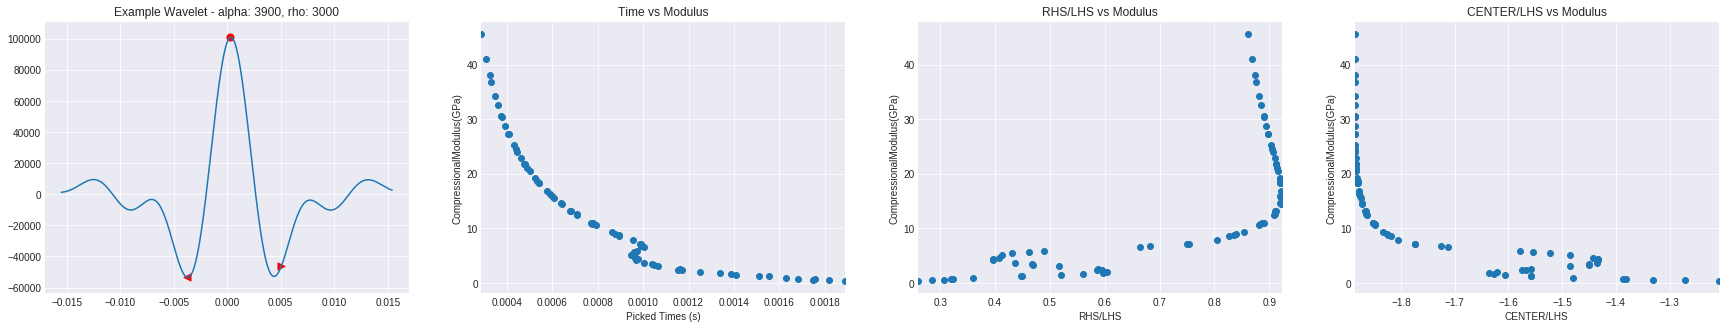

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(15+15, 5))
axes[0].plot(time, w)
axes[0].scatter(delay, amplitude, s=50, c='r')
axes[0].scatter(extracted_features['left']['delay'], extracted_features['left']['amplitude'], s=50, c='r', marker="<")
axes[0].scatter(extracted_features['right']['delay'], extracted_features['right']['amplitude'], s=50, c='r', marker=">")
axes[0].set_title('Example Wavelet - alpha: {}, rho: {}'.format(a, r))
axes[1].scatter(axial_delays, axial_modulus)
axes[1].set_xlabel('Picked Times (s)'); axes[1].set_ylabel('CompressionalModulus(GPa)')
axes[1].set_xlim(axial_delays.min(), axial_delays.max())
axes[1].set_title('Time vs Modulus')
axes[2].scatter(axial_right_to_left_ratio, axial_modulus)
axes[2].set_xlabel('RHS/LHS'); axes[2].set_ylabel('CompressionalModulus(GPa)')
axes[2].set_xlim(axial_right_to_left_ratio.min(), axial_right_to_left_ratio.max())
axes[2].set_title('RHS/LHS vs Modulus')
axes[3].scatter(axial_center_to_left_ratio, axial_modulus)
axes[3].set_xlabel('CENTER/LHS'); axes[3].set_ylabel('CompressionalModulus(GPa)')
axes[3].set_xlim(axial_center_to_left_ratio.min(), axial_center_to_left_ratio.max())
axes[3].set_title('CENTER/LHS vs Modulus')

# Modeling Tangential Times 

In [10]:
beta_range = np.arange(*ROCK_BETA_RANGE)
RHO_RANGE = np.arange(*ROCK_RHO_RANGE)

tangential_delays = []
tangential_modulus = []
tangential_right_to_left_ratio = []
tangential_center_to_left_ratio = []


pipe = Pipe(Rb=Rb, alpha=PIPE_ALPHA, rho=PIPE_RHO, beta=PIPE_BETA, contact_factor=CONTACT_FACTOR_TANGENTIAL)

wavelets = []
for b, r in tqdm(product(beta_range, RHO_RANGE), total=len(list(product(beta_range, RHO_RANGE)))):
    rock = Rock(beta=b, rho=r, component='tangential')
    theoretical = TheoreticalWavelet(pipe, rock, component='tangential', nyquist=5000, filterby=BANDPASS_FILTER)
    time = theoretical.get_time_range_for_window(WINDOW)/1000
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)
    
    w += theoretical.pegleg_rocksteel(delay_in_ms=DELAY_BITSUB_TANGENTIAL, RC=RC_TANGENTIAL, window=None)
#     w = np.gradient(w, theoretical.sampling_interval)
    
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(WINDOW, w)
        
    extracted_features = feature_extractor(w, time, **TANGENTIAL_FEATURE_EXTRACTOR, upsample_to=UPSAMPLE_TO)
    delay = extracted_features['center']['delay']
    amplitude = extracted_features['center']['amplitude']
    right_to_left_ratio = extracted_features['right_to_left_ratio']
    center_to_left_ratio = extracted_features['center_to_left_ratio']
    
    
    tangential_delays.append(delay)
    tangential_right_to_left_ratio.append(right_to_left_ratio)
    tangential_center_to_left_ratio.append(center_to_left_ratio)
    
    mod = ((r/1000)*((b/1000)**2))
    tangential_modulus.append(mod)
    
tangential_delays = np.asarray(tangential_delays)
# tangential_delays = tangential_delays + (0.0000001 - tangential_delays.min())

tangential_modulus = np.asarray(tangential_modulus)
tangential_right_to_left_ratio = np.asarray(tangential_right_to_left_ratio)
tangential_center_to_left_ratio = np.asarray(tangential_center_to_left_ratio)

100%|██████████| 136/136 [00:18<00:00,  7.52it/s]


## Quick QC Tangential

Text(0.5, 1.0, 'CENTER/LHS vs Modulus')

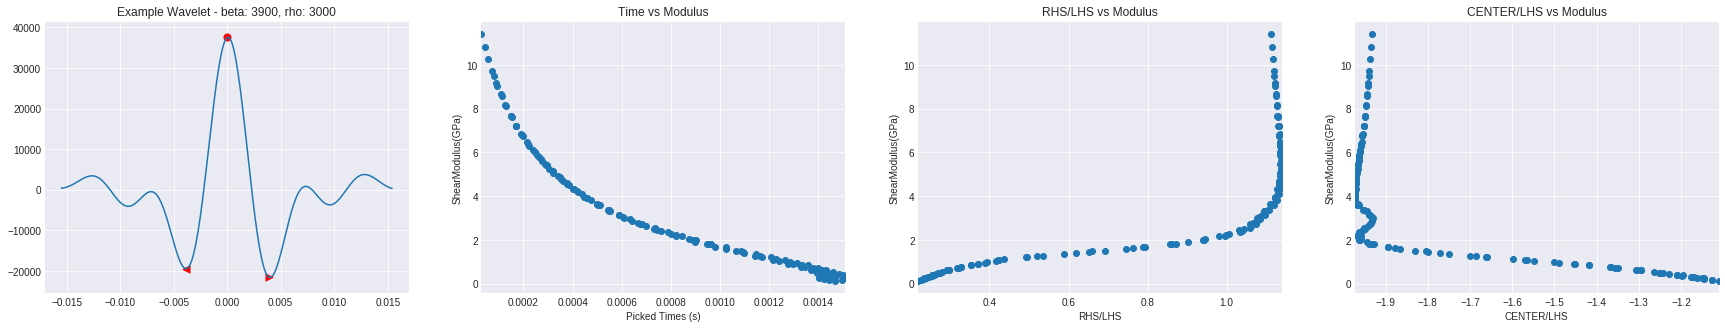

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(15+15, 5))
axes[0].plot(time, w)
axes[0].scatter(delay, amplitude, s=50, c='r')
axes[0].scatter(extracted_features['left']['delay'], extracted_features['left']['amplitude'], s=50, c='r', marker="<")
axes[0].scatter(extracted_features['right']['delay'], extracted_features['right']['amplitude'], s=50, c='r', marker=">")
axes[0].set_title('Example Wavelet - beta: {}, rho: {}'.format(a, r))
axes[1].scatter(tangential_delays, tangential_modulus)
axes[1].set_xlabel('Picked Times (s)'); axes[1].set_ylabel('ShearModulus(GPa)')
axes[1].set_xlim(tangential_delays.min(), tangential_delays.max())
axes[1].set_title('Time vs Modulus')
axes[2].scatter(tangential_right_to_left_ratio, tangential_modulus)
axes[2].set_xlabel('RHS/LHS'); axes[2].set_ylabel('ShearModulus(GPa)')
axes[2].set_xlim(tangential_right_to_left_ratio.min(), tangential_right_to_left_ratio.max())
axes[2].set_title('RHS/LHS vs Modulus')
axes[3].scatter(tangential_center_to_left_ratio, tangential_modulus)
axes[3].set_xlabel('CENTER/LHS'); axes[3].set_ylabel('ShearModulus(GPa)')
axes[3].set_xlim(tangential_center_to_left_ratio.min(), tangential_center_to_left_ratio.max())
axes[3].set_title('CENTER/LHS vs Modulus')

# Check Distribution 

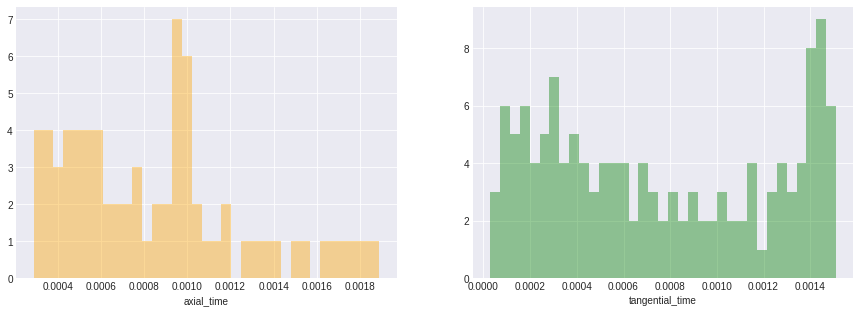

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(axial_delays, axlabel='axial_time', ax=ax1, kde=False, bins=35, color='orange')
sns.distplot(tangential_delays, axlabel='tangential_time', ax=ax2, kde=False, bins=35, color='green')

# A bigger plot of the picked times

(0.02871782871773608, 1.5105906105905078)

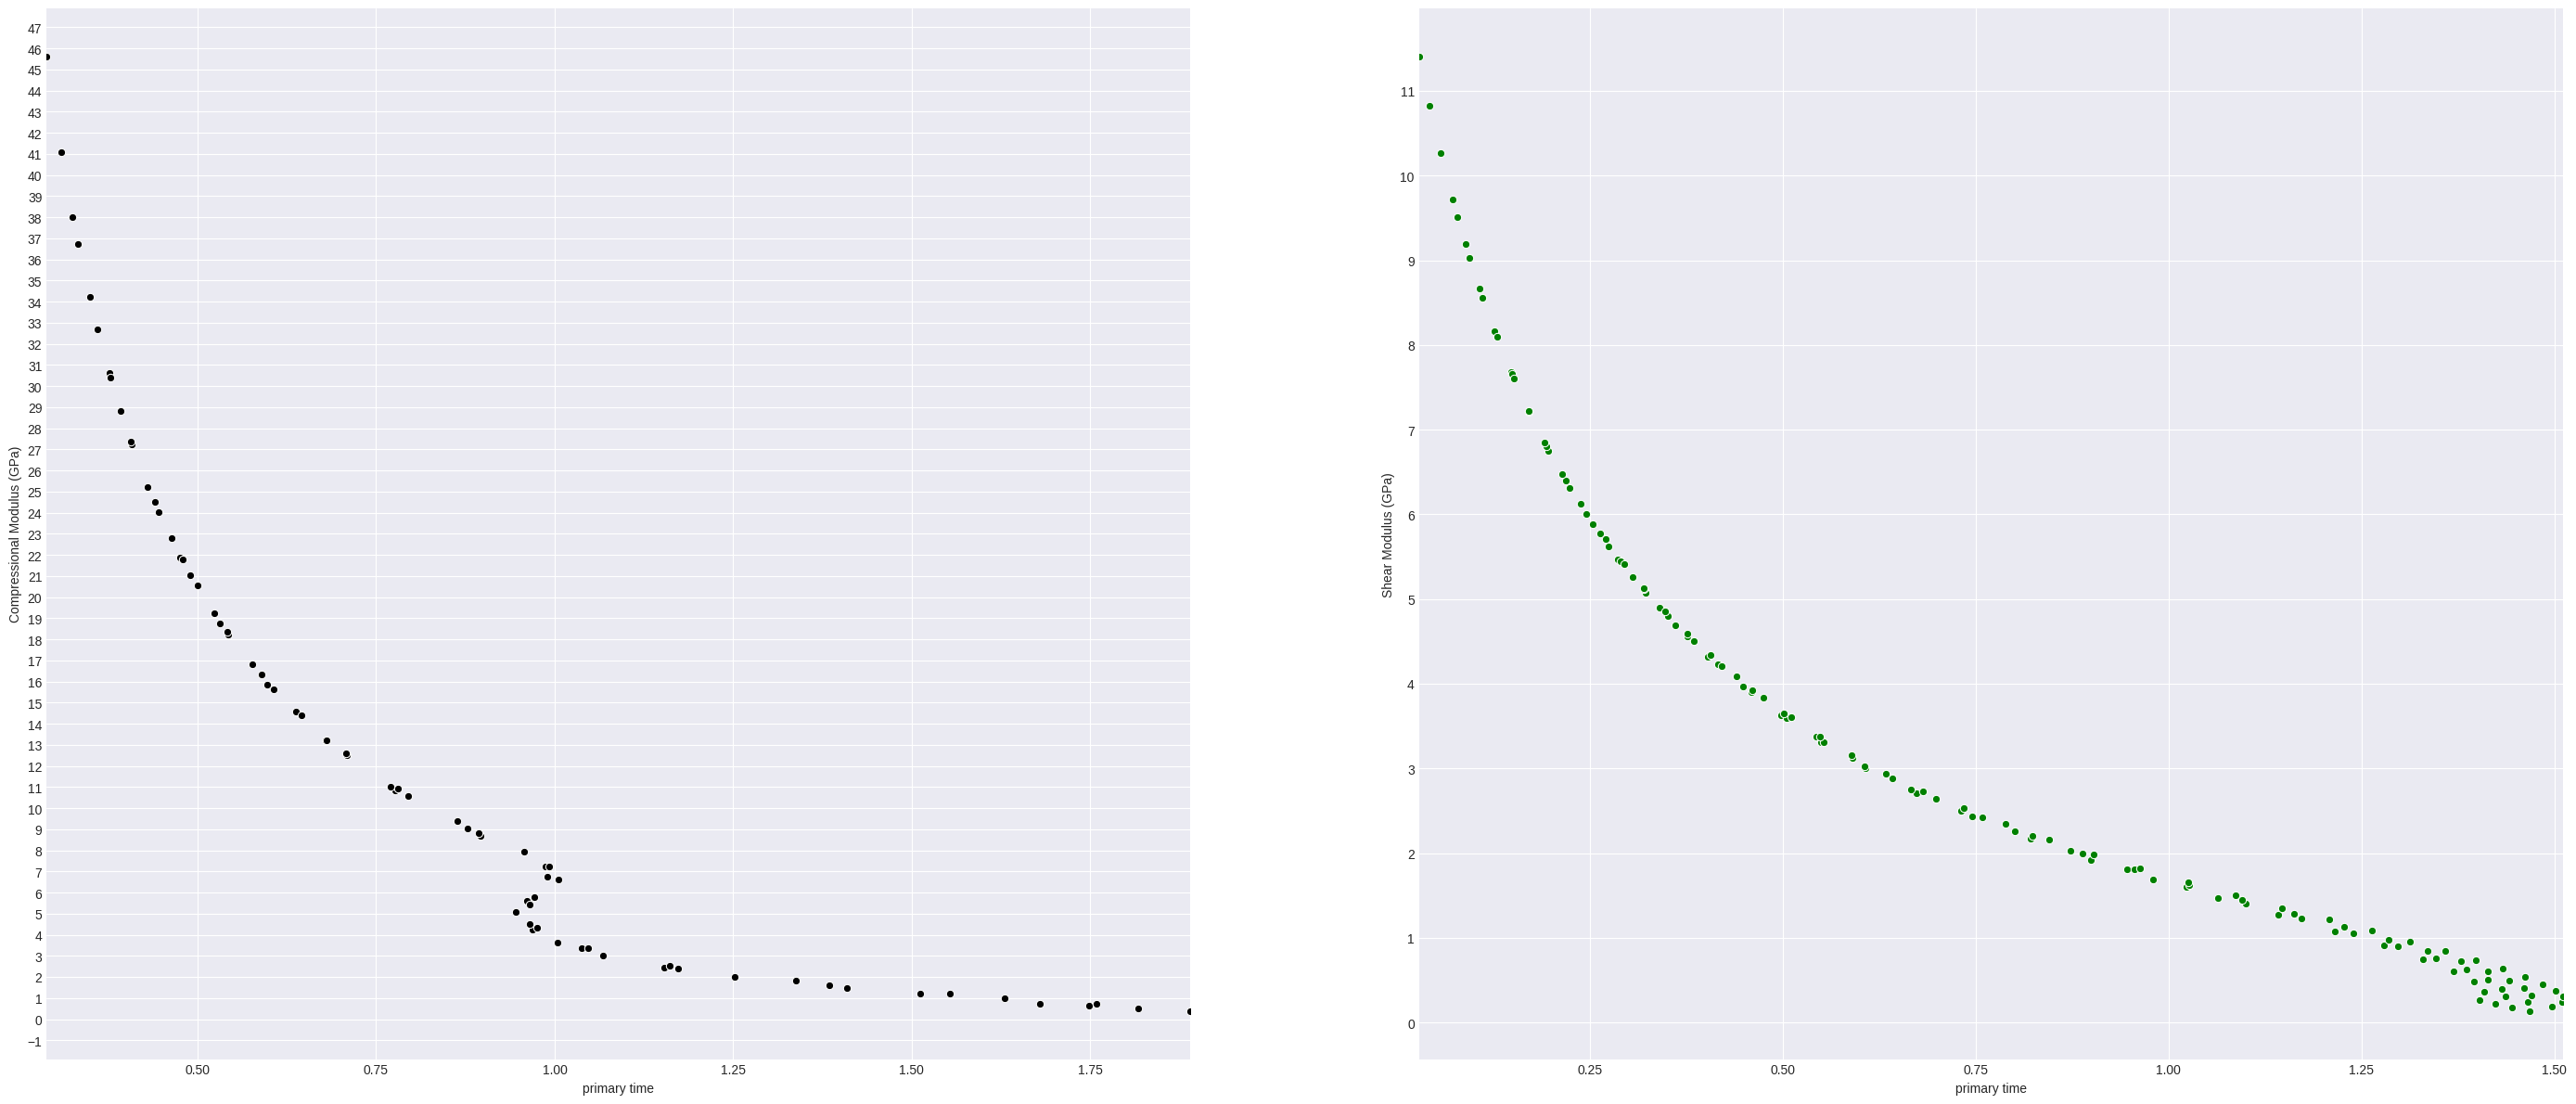

In [13]:
import matplotlib.ticker as ticker


fig, axes = plt.subplots(1, 2, figsize=(35,15), dpi=100, sharey=False)
sns.scatterplot(axial_delays*1000, axial_modulus, ax=axes[0], color='k')
sns.scatterplot(tangential_delays*1000, tangential_modulus, ax=axes[1], color='green')
for ax in axes.ravel():
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.00025*1000))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

axes[0].set_xlabel('primary time')
axes[0].set_ylabel('Compressional Modulus (GPa)')

axes[1].set_xlabel('primary time')
axes[1].set_ylabel('Shear Modulus (GPa)')
#     ax.set_ylim(0, MODULUS_RANGE[1])

axes[0].set_xlim(axial_delays.min()*1000, axial_delays.max()*1000)
axes[1].set_xlim(tangential_delays.min()*1000, tangential_delays.max()*1000)

Modulus is a function of time.

# Modeling

## This is a bunch of functions we can fit our model to. 

In [47]:
from theory.function_handler import ModelingFunction

In [64]:
line_function = ModelingFunction('a * x + b')

power_func = ModelingFunction('a * (x + b)**(c)')
power_func2 = ModelingFunction('(((a * (((x)+b)**c) + d) + (e*x) + f) / (g  * ((x) ** (2)) + h * x + i) * j)')
power_func3 = ModelingFunction('((a * (((x)+b)**c) + d) / (e  * ((x) ** (2)) + f * x + g) * h)')
power_func4 = ModelingFunction('((a * (((x)+b)**c) + d)  / (e * (x) + f) * g)')
exponential_func = ModelingFunction('a * np.exp(-b * np.asarray(x)) + c')

## Select which function to use for each component

In [65]:
from copy import copy 
current_axial_func = copy(line_function)
current_tangential_func = copy(power_func3)

## Removing modulus for the fitting 

In [67]:
cmod = 0.6, 1.75

In [68]:
smod = .35 , 1.5 

In [69]:
axial_modulus_range = (1, 14)

axial_delays_clipped = axial_delays[((axial_modulus) < axial_modulus_range[1]) & (axial_modulus > axial_modulus_range[0])]
axial_modulus_clipped = axial_modulus[((axial_modulus) < axial_modulus_range[1]) & (axial_modulus > axial_modulus_range[0])]
             
# axial_delays_clipped = (1.75/1000, .6/1000)
# axial_modulus_clipped = (1, 14)  
    
tangential_modulus_range = (.5, 5)

tangential_delays_clipped = tangential_delays[((tangential_modulus) < tangential_modulus_range[1]) & (tangential_modulus > tangential_modulus_range[0])]
tangential_modulus_clipped = tangential_modulus[((tangential_modulus) < tangential_modulus_range[1]) & (tangential_modulus > tangential_modulus_range[0])]

# tangential_delays_clipped = (1.5/1000, .35/1000)
# tangential_modulus_clipped = (.5, 5)

In [70]:
## Polynomial fitting 

# ax_x, ax_y = axial_delays_clipped, axial_modulus_clipped
# ax_poly = np.poly1d(np.polyfit(ax_x, ax_y, 12))

# tn_x, tn_y = tangential_delays_clipped, tangential_modulus_clipped
# tn_poly = np.poly1d(np.polyfit(tn_x, tn_y, 7))

In [71]:
current_axial_func.fit( 
    axial_delays_clipped,
    axial_modulus_clipped)

current_tangential_func.fit( 
    tangential_delays_clipped,
    tangential_modulus_clipped,)

# Look at the equations 

In [80]:
print('axial: ', current_axial_func.get_fitted_string())
print()
print('tangential: ', current_tangential_func.get_fitted_string())

axial:  -15281.700281331927 * x + 21.629217029789125

tangential:  ((1.8245631870918197 * (((x)+1.8283454533042165)**-2722.2446355190104) + 6.0862371119219985) / (6284046.415261595  * ((x) ** (2)) + -1215.8063036535186 * x + 1.9858485933269403) * 1.8033846436826022)


In [74]:
import matplotlib.ticker as ticker
import matplotlib

In [75]:
matplotlib.use('agg')

Text(0.5, 0.98, 'Teck - Line Creek')

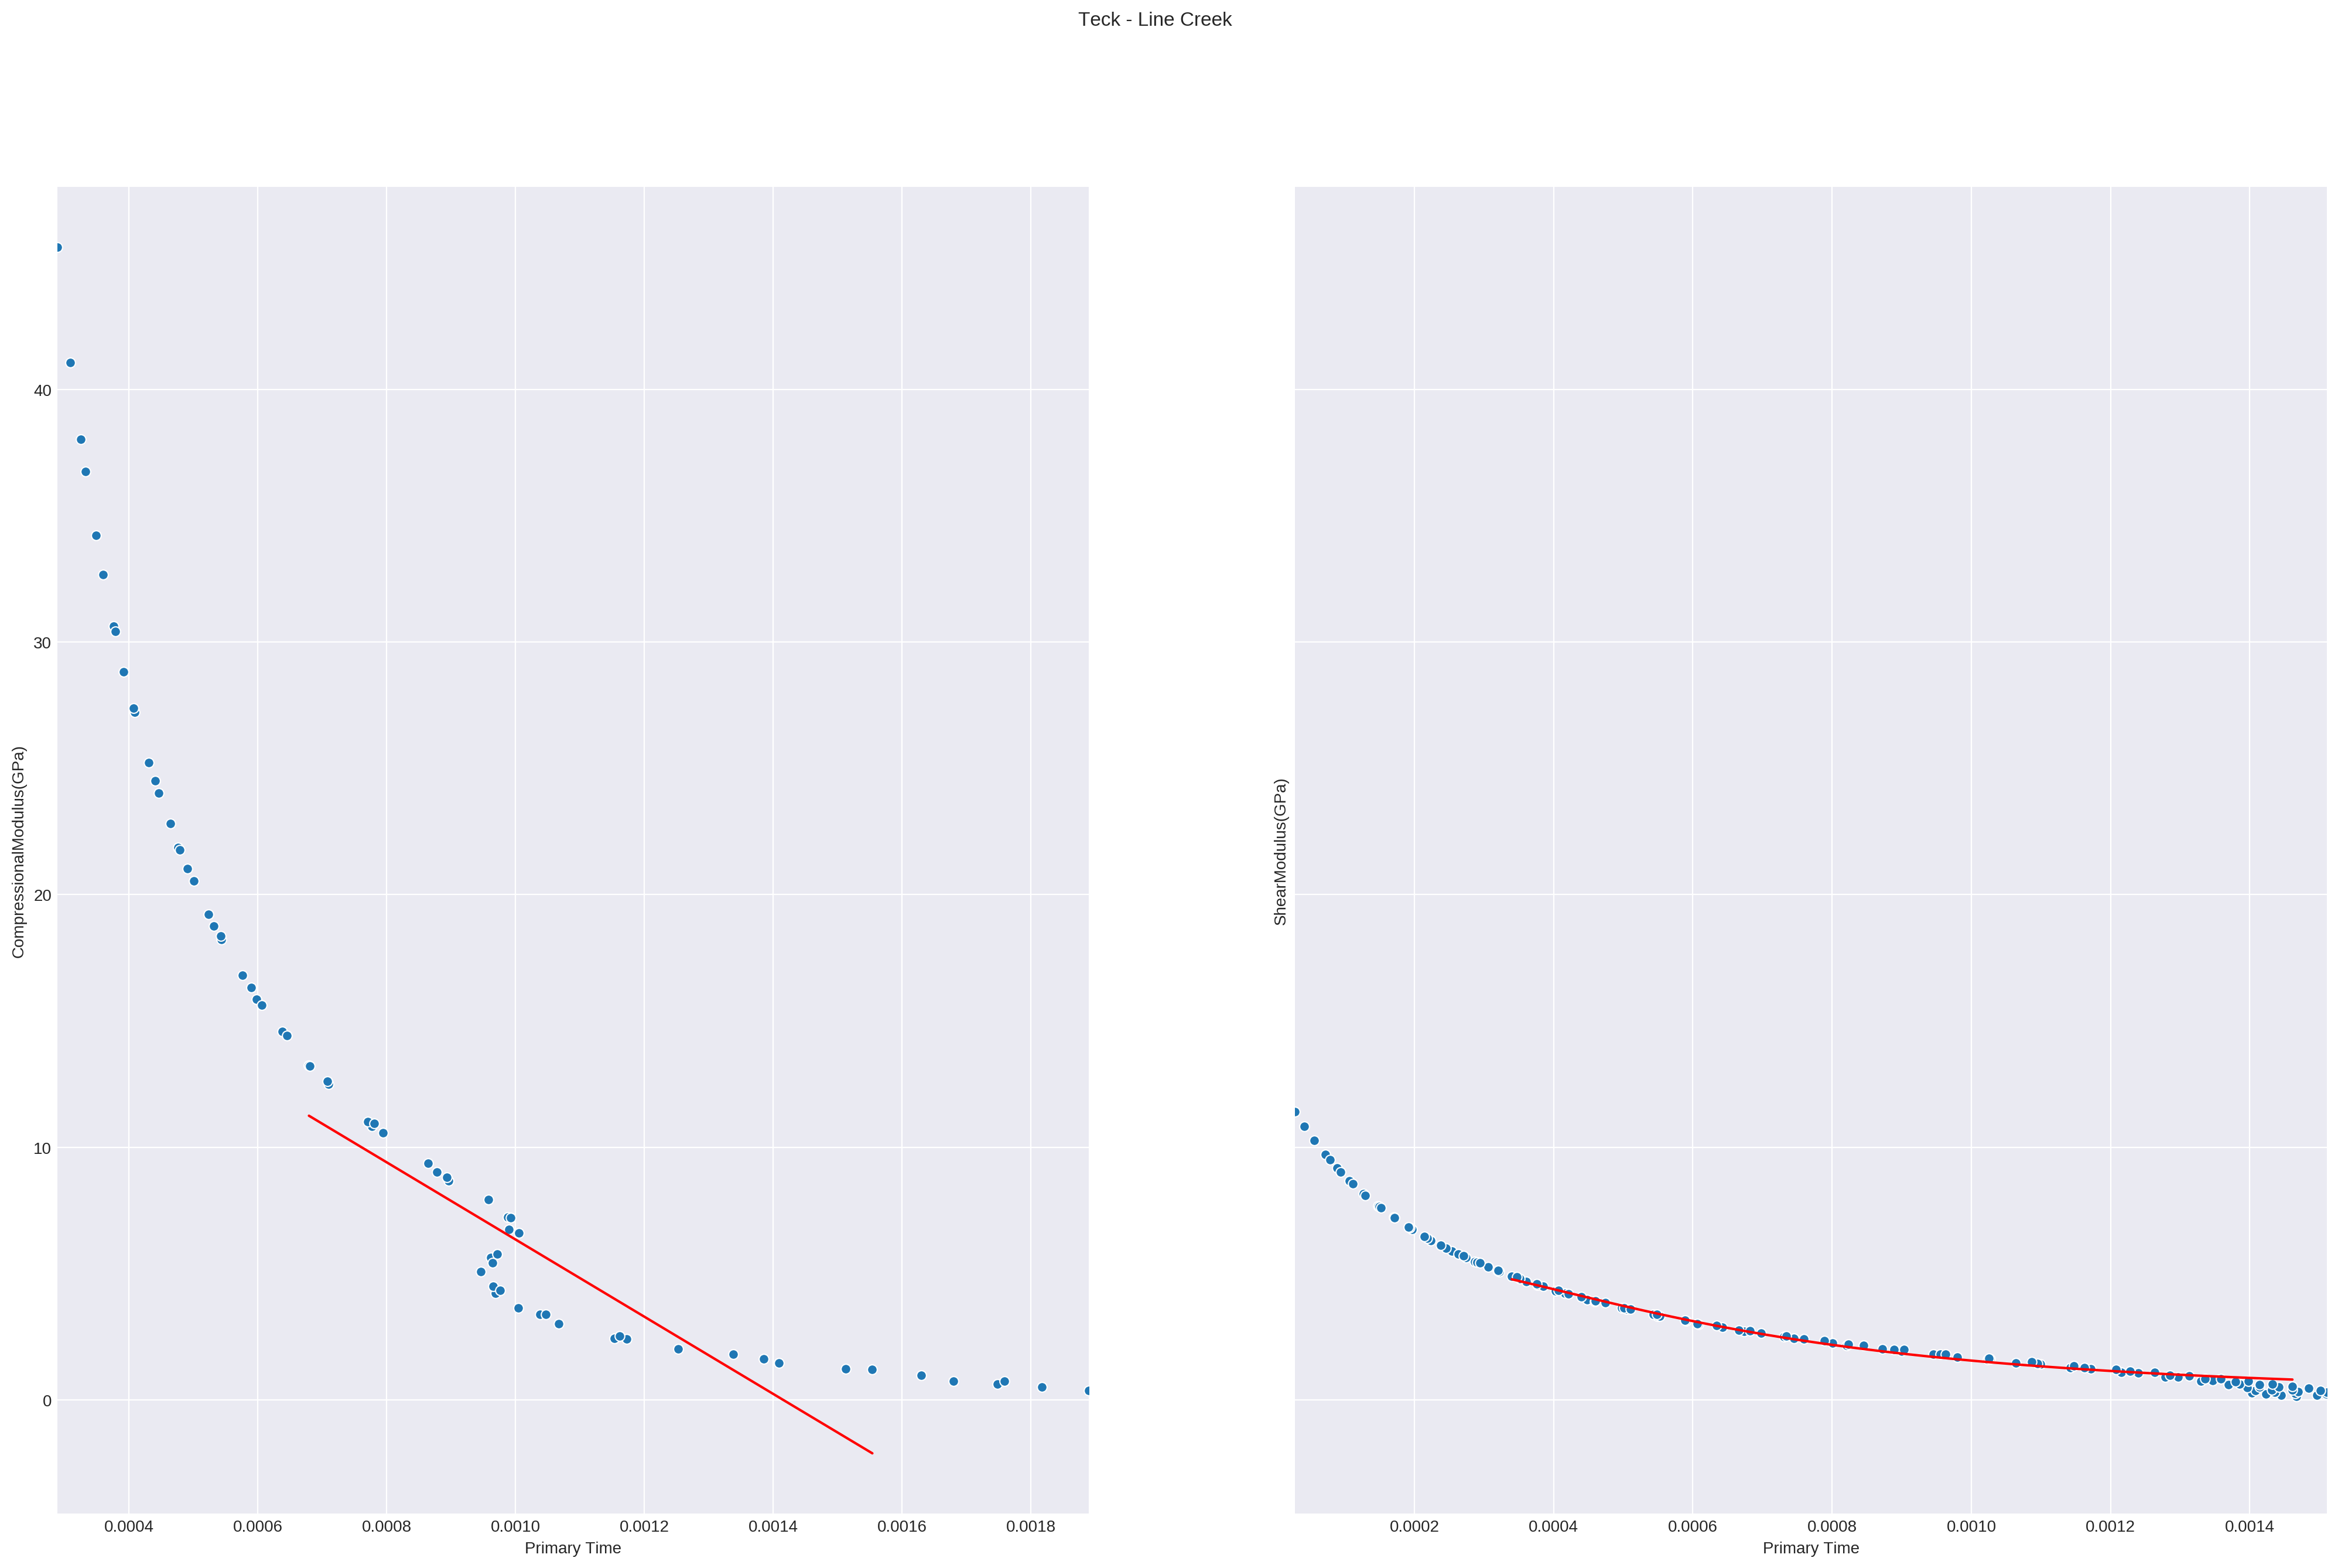

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(25,15), dpi=200, sharey=True)
sns.scatterplot(axial_delays, axial_modulus, ax=axes[0])
sns.scatterplot(tangential_delays, tangential_modulus, ax=axes[1])

axes[0].plot(np.linspace(min(axial_delays_clipped), max(axial_delays_clipped)), current_axial_func.as_partial(np.linspace(min(axial_delays_clipped), max(axial_delays_clipped))), '-', color='r')
axes[1].plot(np.linspace(min(tangential_delays_clipped), max(tangential_delays_clipped)), current_tangential_func.as_partial(np.linspace(min(tangential_delays_clipped), max(tangential_delays_clipped))), '-', color='r')


axes[0].set_xlabel('Primary Time')
axes[0].set_ylabel('CompressionalModulus(GPa)')
axes[1].set_xlabel('Primary Time')
axes[1].set_ylabel('ShearModulus(GPa)')

# axes[0].set_xlim(axial_delays.min(), axial_delays.max())
# axes[1].set_xlim(0.002, tangential_delays.max())

# for ax in axes.ravel():
#     ax.set_ylim(0, MODULUS_RANGE[1])
#     ax.set_yscale('log')

axes[0].set_xlim(axial_delays.min(), axial_delays.max())
axes[1].set_xlim(tangential_delays.min(), tangential_delays.max())
fig.suptitle(MINE)

# Output the functions

no more copy paste

In [77]:
current_axial_func

<Equation: a * x + b - Curve Fitted: True>

In [78]:
current_axial_func.save('/data/datacloud/line_creek/linecreek-axial.model')
current_tangential_func.save('/data/datacloud/line_creek/linecreek-tangential.model')

# Write Lookup Table 

In [74]:
bandpass_str = '-'.join([str(s) for s in BANDPASS_FILTER])

axial_lookup_table = pd.DataFrame(np.c_[np.asarray(list(product(alpha_range, RHO_RANGE))), axial_modulus, axial_delays], columns=['alpha', 'rho', 'modulus', 'primary_time'])
# axial_lookup_table = axial_lookup_table.loc[axial_lookup_table['modulus'] > 7.5]
axial_lookup_table.to_csv('lp_projects/west_angelas//data/20190730-{}-CompressionalModulus_LookupTable.csv'.format(bandpass_str), index=False)

tangential_lookup_table = pd.DataFrame(np.c_[np.asarray(list(product(beta_range, RHO_RANGE))), tangential_modulus, tangential_delays], columns=['beta', 'rho', 'modulus', 'primary_time'])
# tangential_lookup_table = tangential_lookup_table.loc[tangential_lookup_table['modulus'] > 4]
tangential_lookup_table.to_csv('lp_projects/west_angelas/data/20190730-{}-ShearModulus_LookupTable.csv'.format(bandpass_str), index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'lp_projects/west_angelas//data/20190730-20-30-100-120-CompressionalModulus_LookupTable.csv'

# Lookup Table Code

In [ ]:
from scipy.interpolate import interp1d

def lookup_table(shifted_time, modulus):
    return interp1d(shifted_time, modulus, fill_value="extrapolate")

In [ ]:
axial_lookup = pd.read_csv('lp_projects/west_angelas/data/20190730-{}-CompressionalModulus_LookupTable.csv'.format(bandpass_str))
tangential_lookup = pd.read_csv('lp_projects/west_angelas/data/20190730-{}-ShearModulus_LookupTable.csv'.format(bandpass_str))

ALookupTable = lookup_table(axial_lookup.primary_time, axial_lookup.modulus)
TLookupTable = lookup_table(tangential_lookup.primary_time, tangential_lookup.modulus)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(25,15), dpi=200, sharey=True)
sns.scatterplot(axial_delays, axial_modulus, ax=axes[0])
sns.scatterplot(tangential_delays, tangential_modulus, ax=axes[1])

axes[0].plot(np.linspace(axial_delays.min(), axial_delays.max()), ALookupTable(np.linspace(axial_delays.min(), axial_delays.max()).reshape(-1, 1)), '-', color='r')
axes[1].plot(np.linspace(tangential_delays.min(), tangential_delays.max()), TLookupTable(np.linspace(tangential_delays.min(), tangential_delays.max()).reshape(-1, 1)), '-', color='r')

axes[0].set_xlabel('Primary Time')
axes[0].set_ylabel('CompressionalModulus(GPa)')
axes[1].set_xlabel('Primary Time')
axes[1].set_ylabel('ShearModulus(GPa)')